Logs:
[2023/08/28] 
- Implementation of MA(q) in `from statsmodels.tsa.arima_model import ARMA, ARIMA`.    
  is deprecated. Use SARIMAX.

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})


**Function declarations**

In [41]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4)):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  formatter = mdates.DateFormatter("%Y-%b")
  # locator = mdates.YearLocator(base=2)
  locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  for j, label in enumerate(ax.get_xticklabels()):
    label.set_rotation(40)
    label.set_horizontalalignment('right')

  plt.show(fig)


## Introduction 

Suppose that you want to forecast the volume of widget sales
from the XYZ Widget Company.    
By predicting future sales, the
company will be able to better manage its production of widgets    
and avoid producing too many or too feew

In [33]:
file_path = "./datasets/widget_sales_with_date.csv"
df_widget = pd.read_csv(file_path, parse_dates=[0])
df_widget

,date,widget_sales
0,2019-01-01,50.496714
1,2019-01-02,50.805493
2,2019-01-03,51.477758
3,2019-01-04,53.542228
4,2019-01-05,54.873108
...,...,...
495,2020-05-10,64.087371
496,2020-05-11,63.992081
497,2020-05-12,63.029894
498,2020-05-13,61.671797


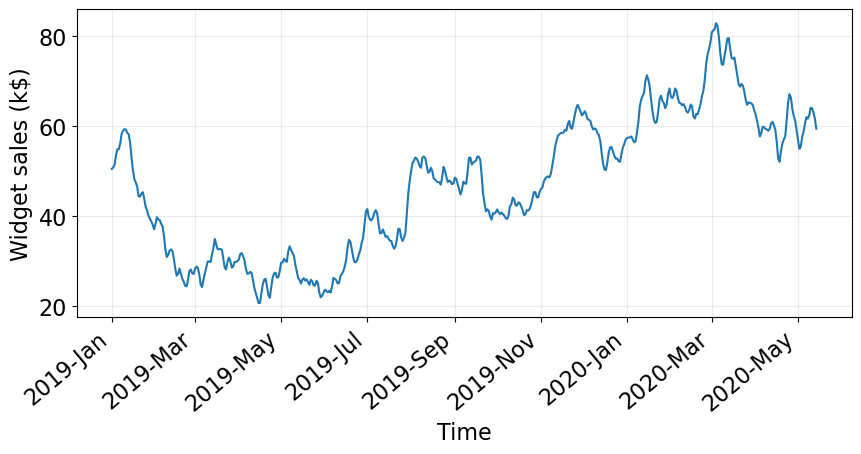

In [42]:
plot_time_series(df_widget["date"], df_widget["widget_sales"],  
  "Time", "Widget sales (k$)")

In this week we will discover that the volume of widget sales from the XYZ
Widget company can be approximated as a moving average process, and
we will look at the definition of moving average model.

## 4.1  Defining a moving average process

**Moving average process**  
In a moving average ($\text{MA}$) process, the current value depends linearly 
onf the man of the series, the current error term, and past error terms.    

The moving average model is denoted as $\text{MA}(q)$, where $q$ is the order.   
The general expression of an $\text{MA}(q)$ model is
$$
  y_t = \mu_t + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2}  
    + \ldots + \theta_q \epsilon_{t-q}
$$

procedure to identify the order of moving average

<img src="./figures/identify-stationary-order-ma.drawio.png" width=600>

Test for stationary

In [35]:
widget_ADF_result = adfuller(df["widget_sales"])
print(f"ADF statistic: {widget_ADF_result[0]}")
print(f"p-value: {widget_ADF_result[1]}")

ADF statistic: -1.5121662069359063
p-value: 0.5274845352272597


The ADF statistic is not a large negative number, and the $p$-value is greater
than 0.05.    
Therefore, our time series is not stationary, and we must apply
transformation to make it stationary.

First difference: $y'_t = y_t - y_{t-1}$

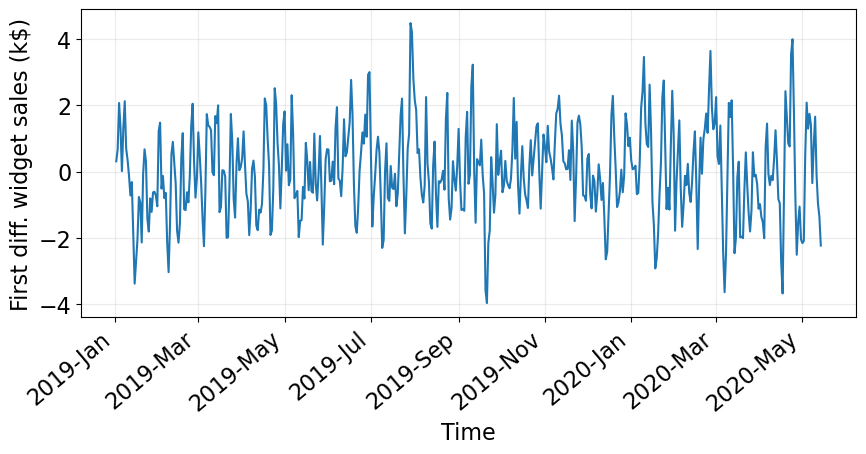

In [43]:
widget_sales_diff = np.diff(df["widget_sales"], n=1)

plot_time_series(df_widget["date"].iloc[1:], widget_sales_diff, ylabel="First diff. widget sales (k$)")


Test for stationarity the first difference of widget sales.

In [44]:
widget_diff_ADF_result = adfuller(widget_sales_diff)
print(f"ADF statistic: {widget_diff_ADF_result[0]}")
print(f"p-value: {widget_diff_ADF_result[1]}")

ADF statistic: -10.576657780341955
p-value: 7.076922818587346e-19


With a large negative ADF statistic and $p$-value much smaller than 0.05, 
we can say that our series is stationary.   
Our next step is to plot the autocorrelation function

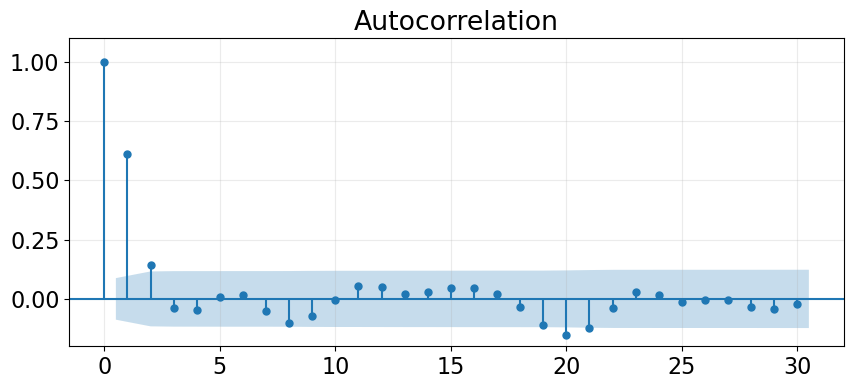

In [49]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(widget_sales_diff, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.grid("on")

plt.show(fig)

In the above plot, we notice that there are significant coefficients up until lag 2.    
Then they abruptly become non-significant, as they remain in the shaded area of the plot.     
This means that we have a stationary moving average process of order 2.    
We can use a second-order moving average model, or $\text{MA}(2)$ model, to forecast our stationary time series.

## 4.2 Forecasting a moving average process

Splitting first difference data of widget sales into train (90%) and test (10%)

In [50]:
df_widget_diff = pd.DataFrame({
  "date": df_widget["date"].iloc[1:],
  "widget_sales_diff": widget_sales_diff})

split_idx = int(0.9 * len(df_widget_diff))
train = df_widget_diff[:split_idx].copy()
test = df_widget_diff[split_idx:]

print(f"(len(train), len(test)): ({len(train)}, {len(test)})")

(len(train), len(test)): (449, 50)


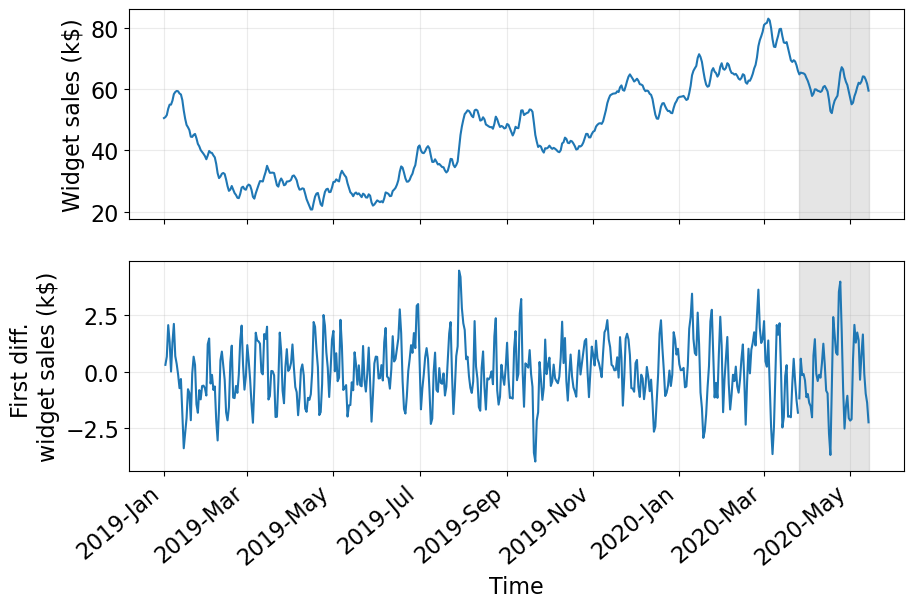

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

axes[0].plot(df_widget['date'], df_widget["widget_sales"])

axes[0].grid("on")
axes[0].set_ylabel("Widget sales (k$)")

# -- second row
axes[1].plot(train["date"], train["widget_sales_diff"])
axes[1].plot(test["date"], test["widget_sales_diff"], color="tab:blue")

formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nwidget sales (k$)")
axes[1].grid("on")


# add forecast area
for j in range(2):
  axes[j].axvspan(test['date'].iloc[0], test['date'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

plt.show(fig)



**Forecasting using the $\text{MA}(q)$ model**    
When using an $\text{MA}(q)$ model, forecasting beyond $q$ steps into the future
will simply return the mean, because there are no error terms to estimate
beyond $q$ steps.     
We can use rolling forecasts to predict up to $q$ steps at a time in order
avoid predicting only the mean of the series.

In [75]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, 
                      method: str) -> list:
  total_len = train_len + horizon

  if method == "mean":
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i]["widget_sales_diff"])
      pred_mean.extend(mean for _ in range(window))

    return pred_mean

  elif method == "last":
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i]["widget_sales_diff"].iloc[-1]
      pred_last_value.extend(last_value for _ in range(window))

    return pred_last_value

  elif method == "MA":
    pred_MA = []

    for i in range(train_len, total_len, window):
      # model = ARMA(df[:i]["widget_sales_diff"], order=(0, 2))
      model = SARIMAX(df[:i]["widget_sales_diff"], order=(0, 0, 2))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_MA.extend(oos_pred)

    return pred_MA

In [76]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_widget_diff, TRAIN_LEN, HORIZON, WINDOW, "mean")
pred_last_value = rolling_forecast(df_widget_diff, TRAIN_LEN, HORIZON, WINDOW, "last")
pred_MA = rolling_forecast(df_widget_diff, TRAIN_LEN, HORIZON, WINDOW, "MA")

pred_df["pred_mean"] = pred_mean
pred_df["pred_last_value"] = pred_last_value
pred_df["pred_MA"] = pred_MA

pred_df.head()

,date,widget_sales_diff,pred_mean,pred_last_value,pred_MA
450,2020-03-26,-1.170131,0.034319,-1.803658,-1.078833
451,2020-03-27,0.580967,0.034319,-1.803658,-0.273309
452,2020-03-28,-0.144902,0.032861,0.580967,0.781223
453,2020-03-29,-0.096564,0.032861,0.580967,0.234969
454,2020-03-30,-0.372334,0.032183,-0.096564,0.168994


Now we can visualize our predictions agains the observed values in the test set.

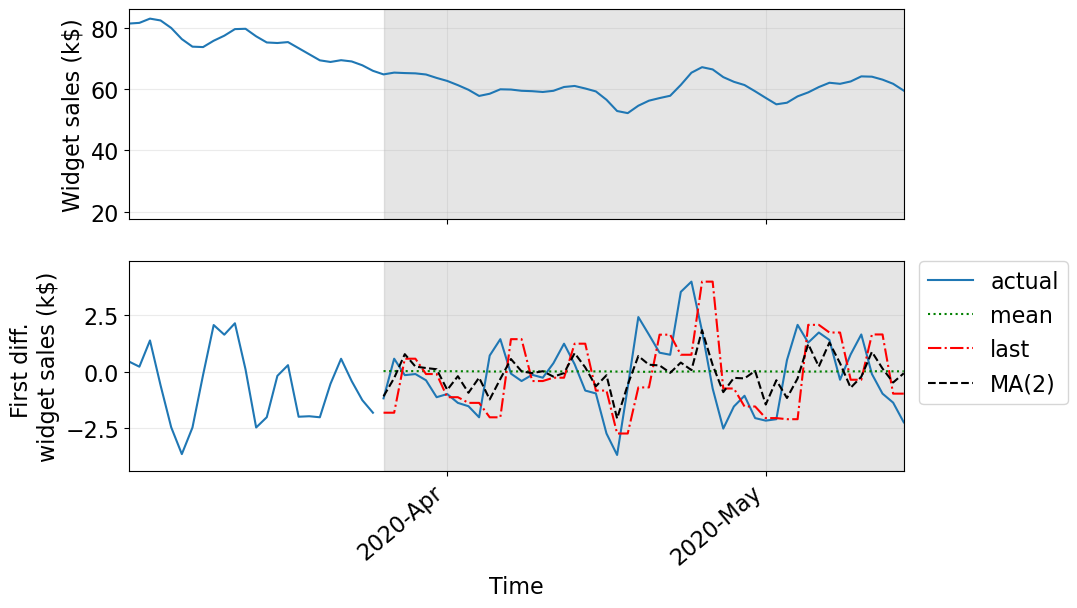

In [92]:
xlim = [train["date"].iloc[425], test["date"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))


# -- second row
axes[1].plot(train["date"], train["widget_sales_diff"])
axes[1].plot(test["date"], test["widget_sales_diff"], color="tab:blue", label="actual")

formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nwidget sales (k$)")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["date"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["date"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["date"], pred_df["pred_MA"], "k--", label="MA(2)")


# add forecast area
for j in range(2):
  axes[j].axvspan(test['date'].iloc[0], test['date'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_widget['date'], df_widget["widget_sales"])

axes[0].grid("on")
axes[0].set_ylabel("Widget sales (k$)")
axes[0].set_xlim(xlim)


plt.show(fig)



Measuring the performance of our models by computing MSE.

In [104]:
mse_mean = mean_squared_error(pred_df["widget_sales_diff"], pred_df["pred_mean"])
mse_last = mean_squared_error(pred_df["widget_sales_diff"], pred_df["pred_last_value"])
mse_MA = mean_squared_error(pred_df["widget_sales_diff"], pred_df["pred_MA"])

print(f"MSE mean: {mse_mean}")
print(f"MSE last: {mse_last}")
print(f"MSE MA: {mse_MA}")

MSE mean: 2.5606299456880537
MSE last: 3.2494260812249225
MSE MA: 1.9481714497544618


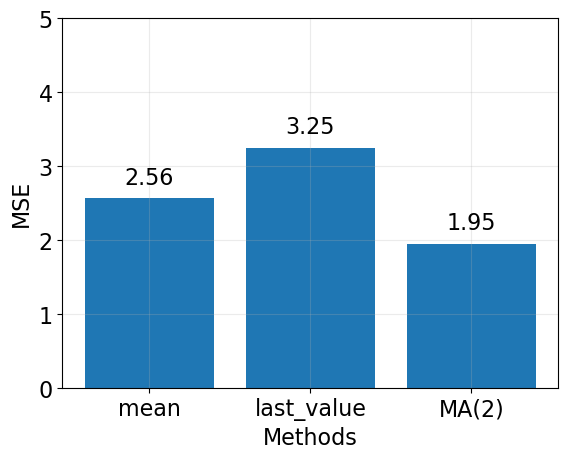

In [128]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(2)"]
y_array = [mse_mean, mse_last, mse_MA]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 5])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)


Now we recover by inverse tranform of our prediction to bring them
back  to the original scale.

$$
\begin{align*}
  y'_1 = y_1 - y_0 \quad &\Rightarrow y_1 = y_0 + y'_1 \\
  y'_2 = y_2 - y_1 \quad &\Rightarrow y_2 = y_1 + y'_2 = (y_0 + y'_1) + y'_2 \\
  y'_3 = y_3 - y_2 \quad &\Rightarrow y_3 = y_2 + y'_3 = (y_1 + y'_2) + y'_3 = ((y_0 + y'_1) + y'_2) + y'_3 \\
  \vdots \\
  y'_N = y_N - y_{N-1} \quad &\Rightarrow 
    y_N = y_{N-1} + y'_N = (y_{N-2} + y'_{N-1}) + y'_N = \ldots 
        = y_0 + \sum_{t=1}^{N} y'_t
\end{align*}
$$

In [119]:
idx_y0 = len(train) + 1 
y0 = df_widget.iloc[idx_y0]["widget_sales"]
# print(y0)
test_df_widget = df_widget[idx_y0:].copy()
test_df_widget["pred_mean"] = y0 + pred_df["pred_mean"].cumsum()
test_df_widget["pred_last_value"] = y0 + pred_df["pred_last_value"].cumsum()
test_df_widget["pred_MA"] = y0 + pred_df["pred_MA"].cumsum()
test_df_widget.head()

,date,widget_sales,pred_mean,pred_last_value,pred_MA
450,2020-03-26,64.736005,64.770324,62.932347,63.657172
451,2020-03-27,65.316972,64.804644,61.128690,63.383863
452,2020-03-28,65.172070,64.837505,61.709657,64.165086
453,2020-03-29,65.075506,64.870366,62.290624,64.400055
454,2020-03-30,64.703173,64.902548,62.194060,64.569050


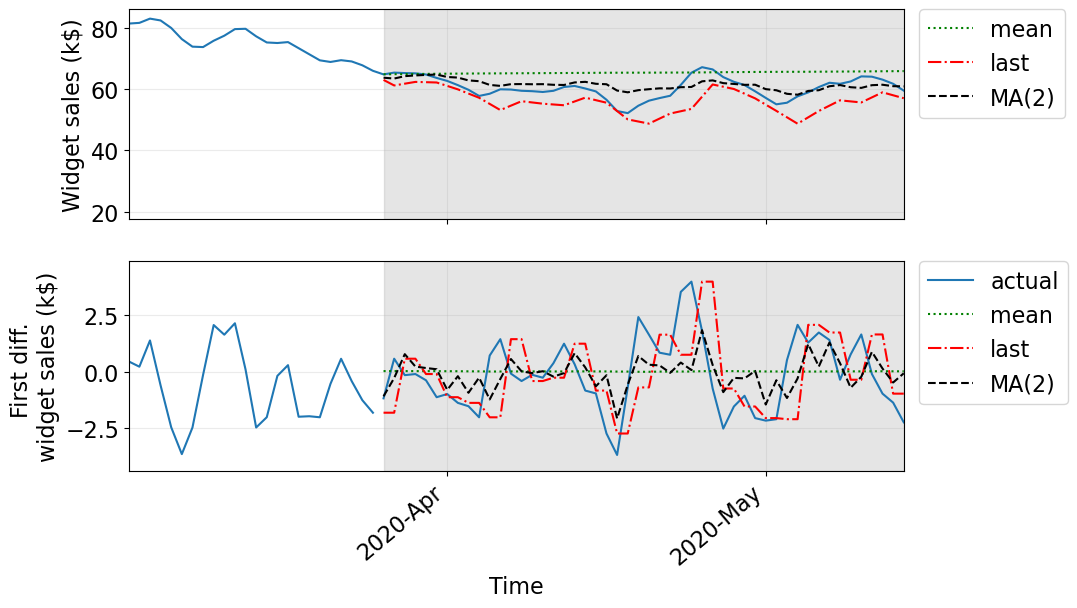

In [120]:
xlim = [train["date"].iloc[425], test["date"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

# -- second row
axes[1].plot(train["date"], train["widget_sales_diff"])
axes[1].plot(test["date"], test["widget_sales_diff"], color="tab:blue", label="actual")

formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nwidget sales (k$)")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["date"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["date"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["date"], pred_df["pred_MA"], "k--", label="MA(2)")


# add forecast area
for j in range(2):
  axes[j].axvspan(test['date'].iloc[0], test['date'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_widget['date'], df_widget["widget_sales"])

# -- prediction for the original data
axes[0].plot(test_df_widget['date'], test_df_widget["pred_mean"], "g:", label="mean")
axes[0].plot(test_df_widget['date'], test_df_widget["pred_last_value"], "r-.", label="last")
axes[0].plot(test_df_widget['date'], test_df_widget["pred_MA"], "k--", label="MA(2)")

axes[0].grid("on")
axes[0].set_ylabel("Widget sales (k$)")
axes[0].set_xlim(xlim)
axes[0].set_ylim()
axes[0].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)


plt.show(fig)




Measure mean absolute error of the original data

In [123]:
mae_mean_undiff = mean_absolute_error(test_df_widget["widget_sales"], test_df_widget["pred_mean"])
mae_last_undiff = mean_absolute_error(test_df_widget["widget_sales"], test_df_widget["pred_last_value"])
mae_MA_undiff   = mean_absolute_error(test_df_widget["widget_sales"], test_df_widget["pred_MA"])

print(f"MAE mean: {mae_mean_undiff}")
print(f"MAE last: {mae_last_undiff}")
print(f"MAE MA: {mae_MA_undiff}")


MAE mean: 5.011974534625542
MAE last: 4.423378873082907
MAE MA: 2.32447092447664


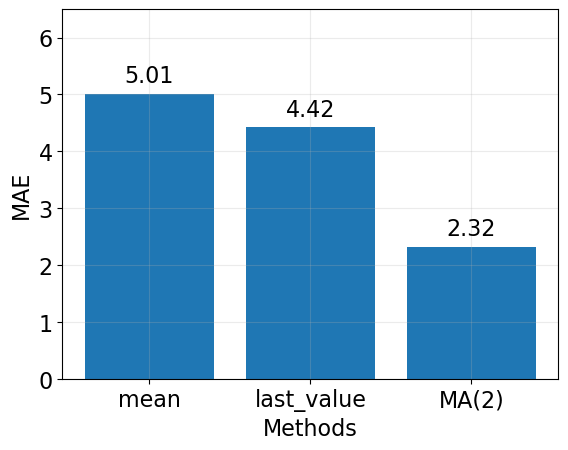

In [127]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(2)"]
y_array = [mae_mean_undiff, mae_last_undiff, mae_MA_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 6.5])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

## 4.3 Next steps

Autoregressive model

## Additional script to fix some bugs

Add date to the `widget_sales.csv`. We assume that for all days in the given dates,
there is a sale.  I found that in the original dataset, some days are skipped.

In [101]:
file_path = "./datasets/widget_sales.csv"
df_widget_with_date = pd.read_csv(file_path)

df_widget_with_date["date"] = pd.date_range(start="2019-01-01", periods=len(df_widget), freq="D")
df_widget_with_date = df_widget_with_date[["date", "widget_sales"]]

df_widget_with_date.to_csv("./datasets/widget_sales_with_date.csv", index=False)

df_widget_with_date


,date,widget_sales
0,2019-01-01,50.496714
1,2019-01-02,50.805493
2,2019-01-03,51.477758
3,2019-01-04,53.542228
4,2019-01-05,54.873108
...,...,...
495,2020-05-10,64.087371
496,2020-05-11,63.992081
497,2020-05-12,63.029894
498,2020-05-13,61.671797


Check the index of `date` to compare with the manual index given in the textbook

In [102]:
idx_df = np.arange(0, len(df_widget_with_date))
idx_df[df_widget_with_date["date"].dt.day == 1]

array([  0,  31,  59,  90, 120, 151, 181, 212, 243, 273, 304, 334, 365,
       396, 425, 456, 486])